
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('docked', 0.046688020755456),
 ('dot', 0.1589865268627092),
 ('mounted', 0.22685454684169398),
 ('watching', 0.1411362504801527),
 ('blink', 0.1817286448065436),
 ('7373', 0.1619412292430009),
 ('icrc', 0.0749569030656185),
 ('maher', 0.07484299310086841),
 ('485', 0.095991006908172),
 ('quadmation', 0.18819404816424326),
 ('selections', 0.05464092321093494),
 ('nirvana', 0.1109950967372947),
 ('wlist', 0.12601141569529475),
 ('puke', 0.19706119834212132),
 ('estate', 0.242206441914102),
 ('hilarious', 0.16299450361806797),
 ('xtian', 0.15540750198460515),
 ('suburbs', 0.05749878121929968),
 ('demystifying', 0.04330392033255178),
 ('136', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['dot', 'manual', 've', 'group', 'font', 'problem', 'kind', 'graphics', '49', 'live'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("for our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

We can also look at the contents of the clusters:

In [18]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 drive
 apple
 like
 don
 new


Cluster 1:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 email
 price


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [19]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [20]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [21]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('misc.forsale', 'green'), ('comp.windows.x', 'orange'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

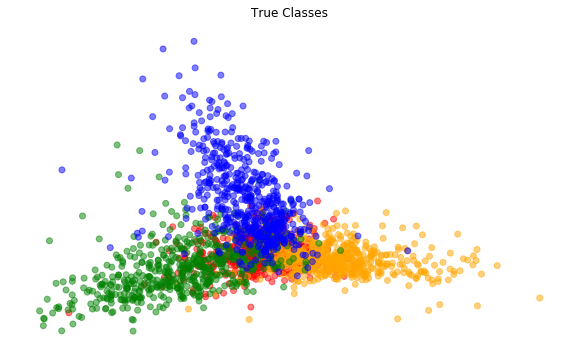

In [22]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

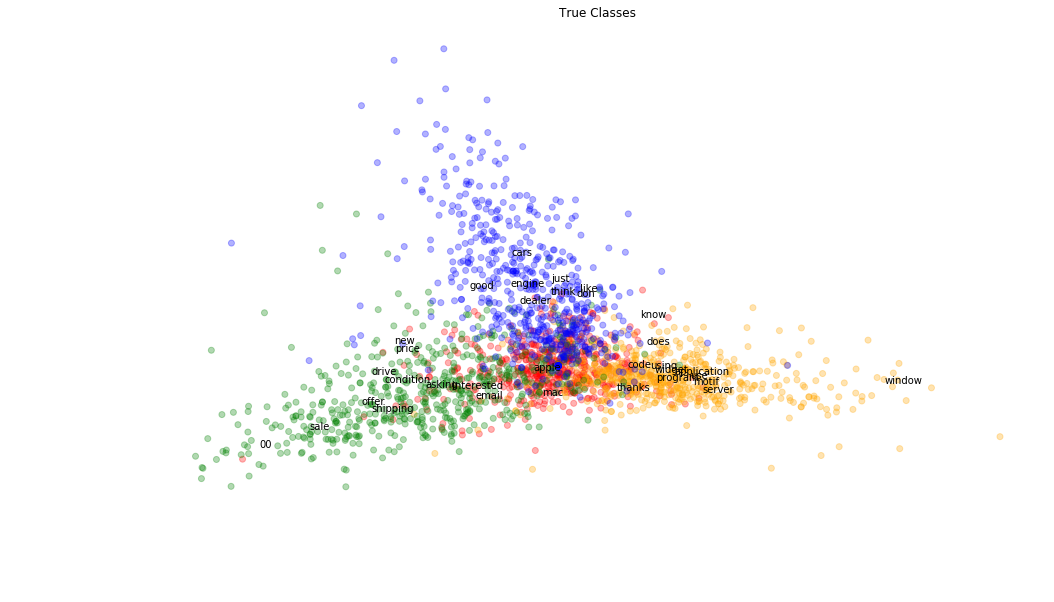

In [23]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [24]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

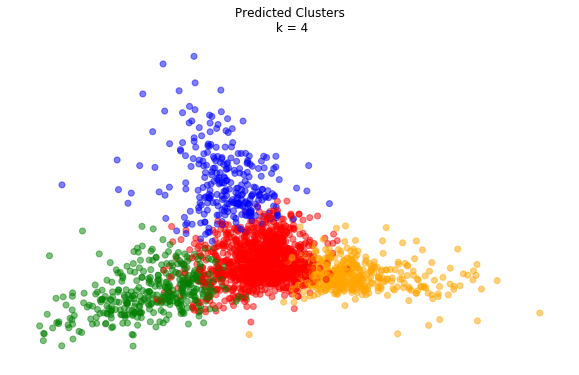

In [25]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [26]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

Now we demonstrate the Silhouette method, one approach by which optimal number of clusters can be ascertained. Many other methods exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [27]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

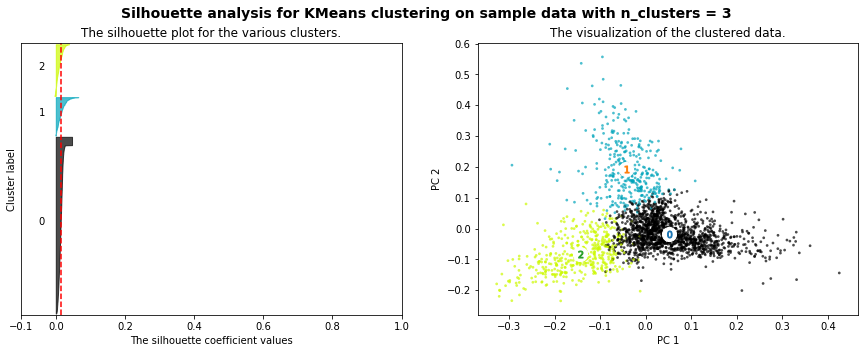

For n_clusters = 3, The average silhouette_score is : 0.014


In [28]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

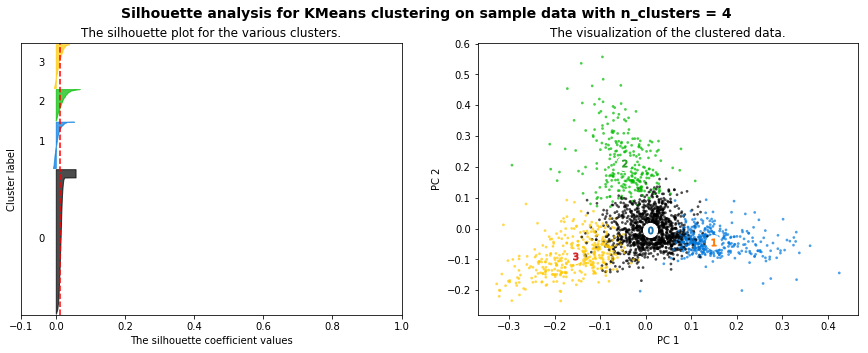

For n_clusters = 4, The average silhouette_score is : 0.012


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

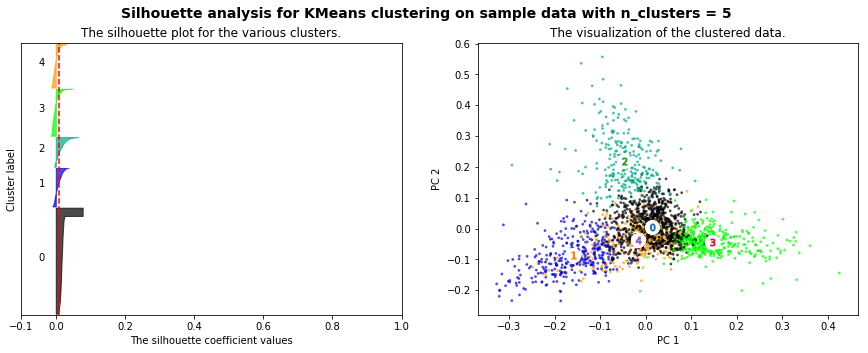

For n_clusters = 5, The average silhouette_score is : 0.010


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

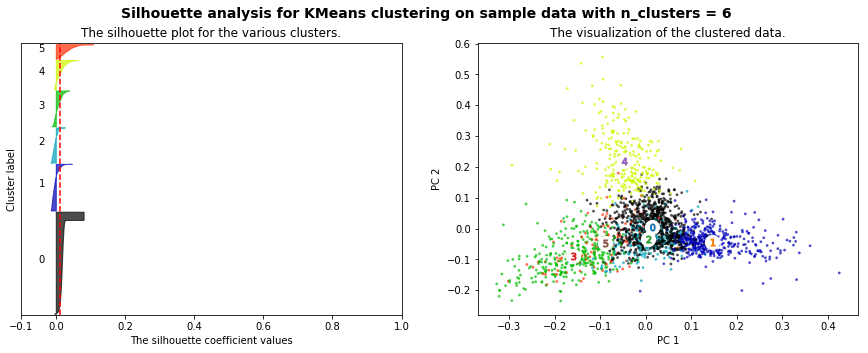

For n_clusters = 6, The average silhouette_score is : 0.011


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting arbitrary text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [32]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [33]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [34]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [35]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [36]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [37]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize, this is more up to you, but we will do one

In [38]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

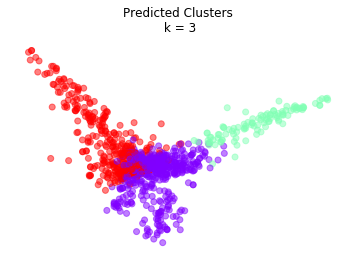

In [39]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there are probably two clusters. You can check with a Silhouette analysis.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

The corpora I'm using are plot summaries of films from four directors, Woody Allen, Alfred Hitchcock, Tim Burton, and Stanley Kubrick, collected from Wikipedia. I'm trying to see if machine learning can automatically categorize the corpora into four groups of directors, if not, what might be the reasons. This might give us some hints on the cinematic styles of different directors.

In [40]:
# Read data into a pandas dataframe
plot = pandas.read_excel("plot.xlsx", sep='\t')
print(plot[:5])

           director                                               plot
0  Alfred Hitchcock  A young blonde woman, her golden hair illumina...
1  Alfred Hitchcock  A previously undefeated fairground boxer named...
2  Alfred Hitchcock  At an expensive English boarding school for bo...
3  Alfred Hitchcock  In 1926, Larita Filton (Isabel Jeans) testifie...
4  Alfred Hitchcock  The Heiress Betty (Betty Balfour) draws the ir...


In [41]:
print('The number of films included in this corpora:')
print('Woody Allen:', len(plot[plot['director'] == 'Woody Allen']), 'films')
print('Alfred Hitchcock:', len(plot[plot['director'] == 'Alfred Hitchcock']), 'films')
print('Tim Burton:', len(plot[plot['director'] == 'Tim Burton']), 'films')
print('Stanley Kubrick:', len(plot[plot['director'] == 'Stanley Kubrick']), 'films')

The number of films included in this corpora:
Woody Allen: 29 films
Alfred Hitchcock: 38 films
Tim Burton: 19 films
Stanley Kubrick: 12 films


In [42]:
# tf-idf vectorizing and filtering
## Remove stop words, corpus-specific stop words, and words appear in only two document
plotTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.7, min_df=3, stop_words='english', norm='l2')
plotTFVects = plotTFVectorizer.fit_transform(plot['plot'])
plotTFVects

<98x2253 sparse matrix of type '<class 'numpy.float64'>'
	with 16180 stored elements in Compressed Sparse Row format>

In [43]:
# Have a look at the tf-idf for each word in each text
list(zip(plotTFVectorizer.vocabulary_.keys(), plotTFVects.data))[:10]

[('happiness', 0.13298471965786407),
 ('watching', 0.12769318445382608),
 ('diplomat', 0.06956020382771537),
 ('estate', 0.1257179819009558),
 ('virgil', 0.06587226025467584),
 ('climb', 0.1257179819009558),
 ('gone', 0.06587226025467584),
 ('apparently', 0.11620880949665631),
 ('group', 0.04664860566894094),
 ('handsome', 0.06587226025467584)]

In [44]:
# Look up the index of each word using the Vectorizer
plotTFVectorizer.vocabulary_.get('quarters')

1576

In [45]:
# The true number of clusters
plotnumClusters = len(set(plot['director']))
plotnumClusters

4

In [46]:
# Running K-means
plotKM = sklearn.cluster.KMeans(n_clusters = 4, init='k-means++')
plotKM.fit(plotTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
# Evaluate the clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(plot['director'], plotKM.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(plot['director'], plotKM.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(plot['director'], plotKM.labels_)))

Homogeneity: 0.076
Completeness: 0.086
V-measure: 0.081


In [48]:
# Look at the contents of the clusters
plot_terms = plotTFVectorizer.get_feature_names()
print("Top terms per cluster:")
plot_order_centroids = plotKM.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print('\n')
    print("Cluster %d:" % i)
    for ind in plot_order_centroids[i, :10]:
        print(' %s' % plot_terms[ind])

Top terms per cluster:


Cluster 0:
 batman
 george
 betty
 wood
 edward
 stanley
 bruce
 mrs
 police
 johnny


Cluster 1:
 police
 father
 mother
 miss
 tells
 man
 mrs
 alice
 john
 ben


Cluster 2:
 ray
 virgil
 danny
 new
 victor
 van
 melody
 family
 alice
 apartment


Cluster 3:
 jack
 judy
 sally
 antonio
 sam
 danny
 juan
 bob
 helena
 charles


In [49]:
# Reduce the dimensionality of the data using PCA
PCA = sklearn.decomposition.PCA
plot_pca = PCA(n_components = 2).fit(plotTFVects.toarray())
plot_reduced_data = plot_pca.transform(plotTFVects.toarray())

In [50]:
# Biplot preparation
plot_components = plot_pca.components_
plot_keyword_ids = list(set(plot_order_centroids[:, :10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
plot_words = [plot_terms[i] for i in plot_keyword_ids]#Turn the ids into words.
plot_x = plot_components[:, plot_keyword_ids][0,:] #Find the coordinates of those words in your biplot.
plot_y = plot_components[:, plot_keyword_ids][1,:]

In [51]:
# Build a color map for the true labels
plot_colordict = {
'Woody Allen': 'red',
'Alfred Hitchcock': 'orange',
'Tim Burton': 'green',
'Stanley Kubrick': 'blue'
    }
plot_colors = [plot_colordict[c] for c in plot['director']]
print("The categories' colors are:\n{}".format(plot_colordict.items()))

The categories' colors are:
dict_items([('Woody Allen', 'red'), ('Alfred Hitchcock', 'orange'), ('Tim Burton', 'green'), ('Stanley Kubrick', 'blue')])


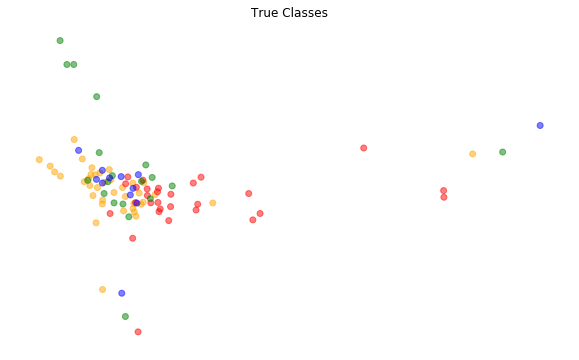

In [52]:
# Plot the data using the true labels as the colors of our data points
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors, alpha = 0.5, label = plot_colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

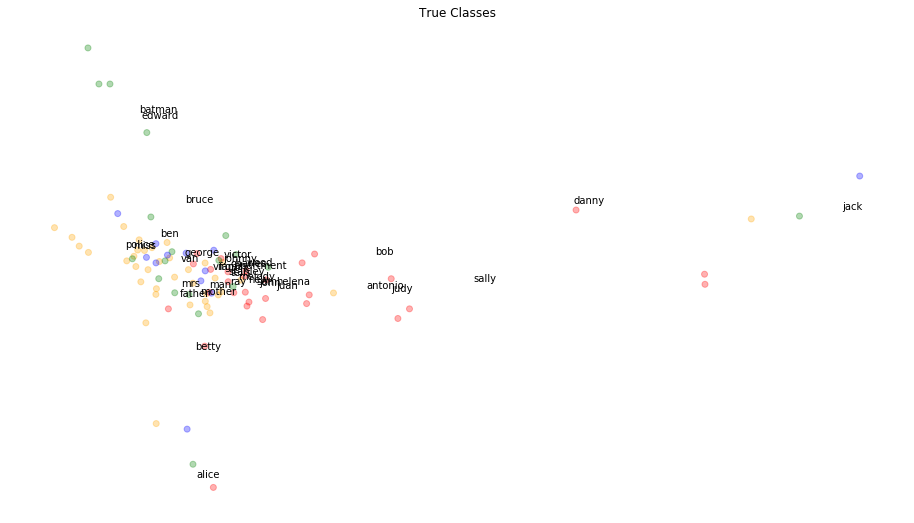

In [53]:
# Do a biplot and map our feature vectors to the same space using the true labels as the colors of our data points
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors, alpha = 0.3, label = plot_colors)
for i, word in enumerate(plot_words):
    ax.annotate(word, (plot_x[i], plot_y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

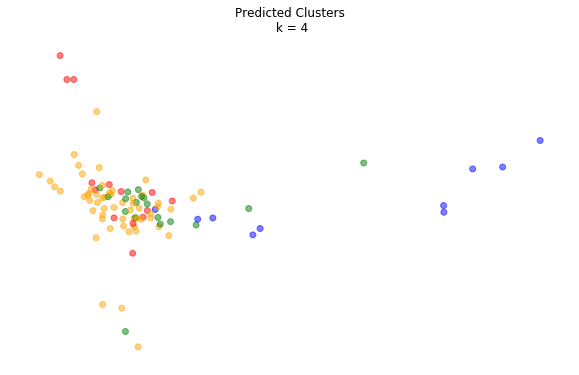

In [54]:
# Plot the data with predicted clusters
plotCategories = ['Woody Allen', 'Alfred Hitchcock', 'Tim Burton', 'Stanley Kubrick']
plot_colors_p = [plot_colordict[plotCategories[l]] for l in plotKM.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

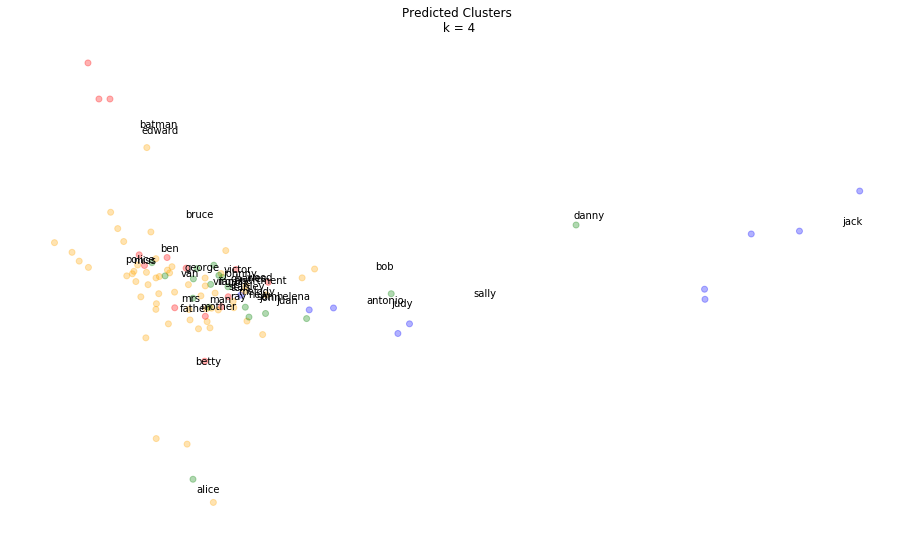

In [55]:
# Do a biplot and map our feature vectors with predicted clusters
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors_p, alpha = 0.3, label = plot_colors_p)
for i, word in enumerate(plot_words):
    ax.annotate(word, (plot_x[i], plot_y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [56]:
# Select cluster number using Silhouette method
def plotSilhouette(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on plot data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

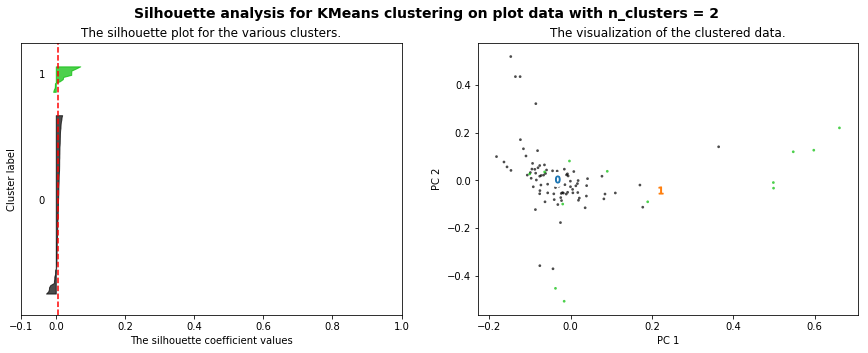

For n_clusters = 2, The average silhouette_score is : 0.007


In [57]:
## 2 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(2, plot_X, plot_reduced_data, plot_pca)

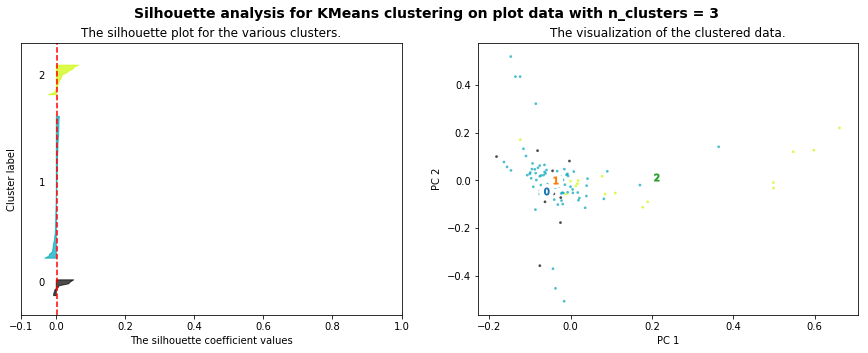

For n_clusters = 3, The average silhouette_score is : 0.004


In [58]:
## 3 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(3, plot_X, plot_reduced_data, plot_pca)

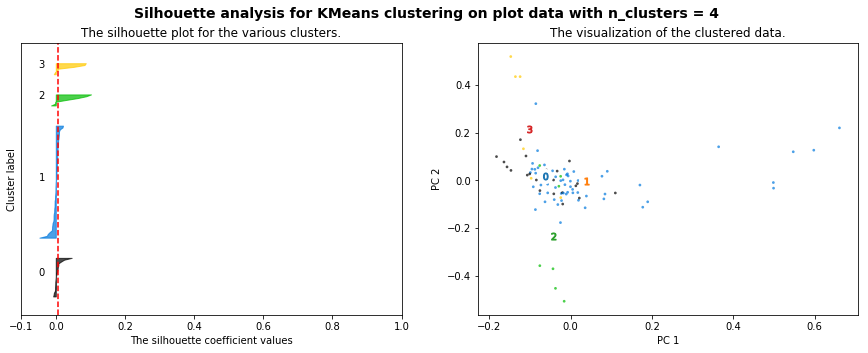

For n_clusters = 4, The average silhouette_score is : 0.005


In [59]:
## 4 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(4, plot_X, plot_reduced_data, plot_pca)

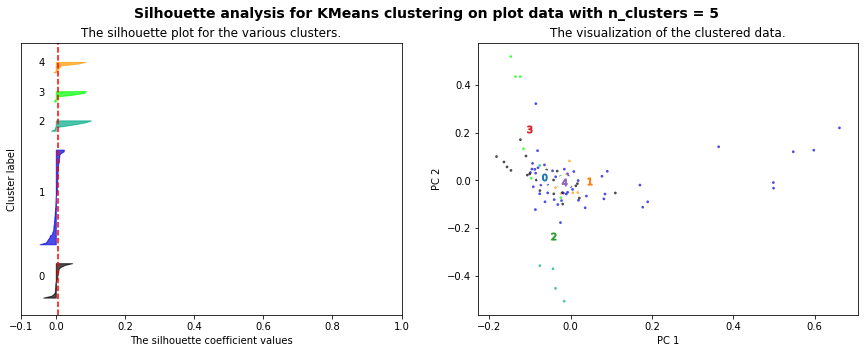

For n_clusters = 5, The average silhouette_score is : 0.007


In [60]:
## 5 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(5, plot_X, plot_reduced_data, plot_pca)

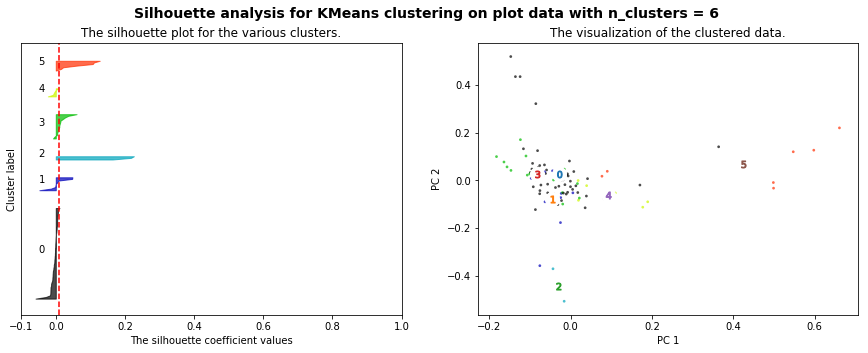

For n_clusters = 6, The average silhouette_score is : 0.010


In [61]:
## 6 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(6, plot_X, plot_reduced_data, plot_pca)

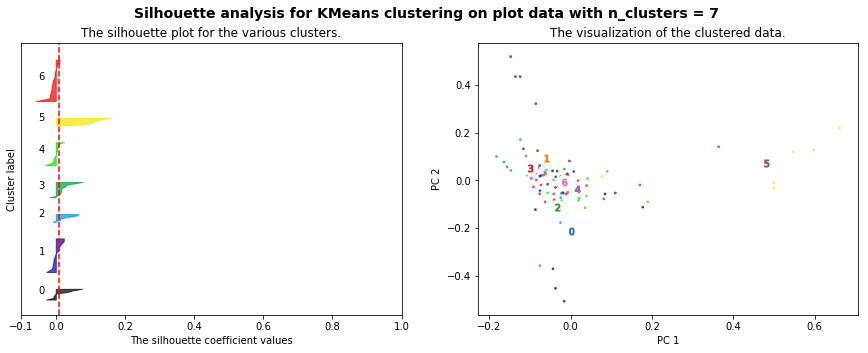

For n_clusters = 7, The average silhouette_score is : 0.009


In [62]:
## 7 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(7, plot_X, plot_reduced_data, plot_pca)

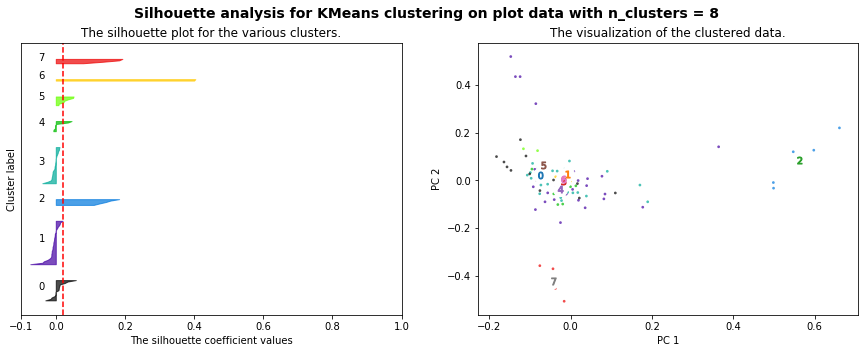

For n_clusters = 8, The average silhouette_score is : 0.021


In [63]:
## 8 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(8, plot_X, plot_reduced_data, plot_pca)

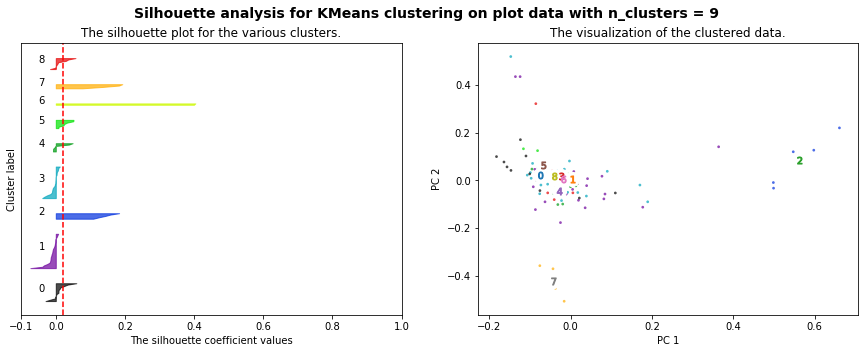

For n_clusters = 9, The average silhouette_score is : 0.022


In [64]:
## 9 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(9, plot_X, plot_reduced_data, plot_pca)

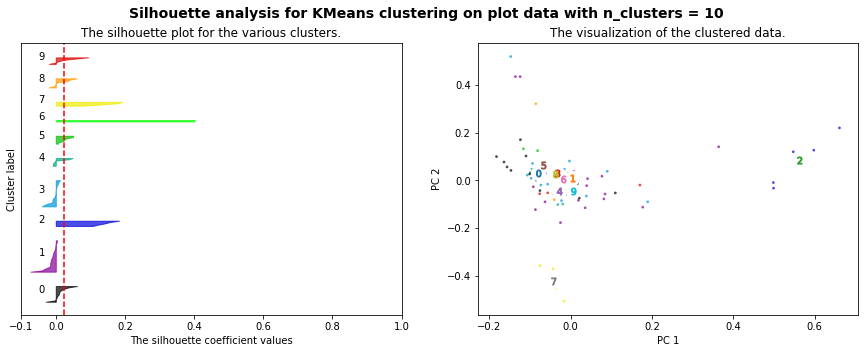

For n_clusters = 10, The average silhouette_score is : 0.024


In [65]:
## 10 clusters
plot_X = plotTFVects.toarray()
plotSilhouette(10, plot_X, plot_reduced_data, plot_pca)

The "optimal" cluster number I found is 8 because from 7 clusters to 8 clusters, we can observe a leap in silhouette score, but when deviding the documents into more than 8 clusters, the improvement in silhouette score is small. Thus, to limit the number of clusters with the desire of obtaining a good performance of clustering, I decide that 8 clusters is reasonable.

In [66]:
# Running K-means with 8 clusters
plotKM8 = sklearn.cluster.KMeans(n_clusters = 8, init='k-means++')
plotKM8.fit(plotTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [67]:
# Evaluate the clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(plot['director'], plotKM8.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(plot['director'], plotKM8.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(plot['director'], plotKM8.labels_)))

Homogeneity: 0.203
Completeness: 0.151
V-measure: 0.173


In [68]:
# Look at the contents of the clusters in terms of features
plot_terms8 = plotTFVectorizer.get_feature_names()
print("Top terms per cluster:")
plot_order_centroids8 = plotKM8.cluster_centers_.argsort()[:, ::-1]
for i in range(8):
    print('\n')
    print("Cluster %d:" % i)
    for ind in plot_order_centroids8[i, :10]:
        print(' %s' % plot_terms8[ind])

Top terms per cluster:


Cluster 0:
 president
 general
 johnny
 leo
 war
 soldiers
 base
 attack
 states
 earth


Cluster 1:
 jack
 mrs
 judy
 sam
 mother
 john
 sally
 new
 antonio
 george


Cluster 2:
 betty
 father
 danny
 margaret
 emily
 victor
 man
 ann
 paris
 david


Cluster 3:
 virgil
 glasses
 interviews
 footage
 frequent
 target
 stock
 age
 documentary
 knew


Cluster 4:
 batman
 edward
 bruce
 wayne
 gotham
 robin
 face
 celebrity
 numerous
 lee


Cluster 5:
 ben
 edward
 harry
 cliff
 train
 hollywood
 brother
 miss
 lucy
 york


Cluster 6:
 police
 mary
 mr
 train
 eve
 miles
 martin
 victor
 mark
 miss


Cluster 7:
 alice
 queen
 joe
 red
 doug
 costume
 men
 society
 white
 dr


In [69]:
# Look at the contents of the clusters in terms of documents
plot['KM_preds'] = plotKM8.labels_
plot

,director,plot,KM_preds
0,Alfred Hitchcock,"A young blonde woman, her golden hair illumina...",1
1,Alfred Hitchcock,A previously undefeated fairground boxer named...,1
2,Alfred Hitchcock,At an expensive English boarding school for bo...,2
3,Alfred Hitchcock,"In 1926, Larita Filton (Isabel Jeans) testifie...",1
4,Alfred Hitchcock,The Heiress Betty (Betty Balfour) draws the ir...,2
5,Alfred Hitchcock,"Barry Fitzgerald, who played Captain Jack Boyl...",0
6,Alfred Hitchcock,"In 1930, Diana Baring (Norah Baring), a young ...",6
7,Alfred Hitchcock,The plot concerns a feud between two affluent ...,6
8,Alfred Hitchcock,"A couple, Fred (Henry Kendall) and Emily Hill ...",2
9,Alfred Hitchcock,Detective Barton is searching for a necklace s...,5


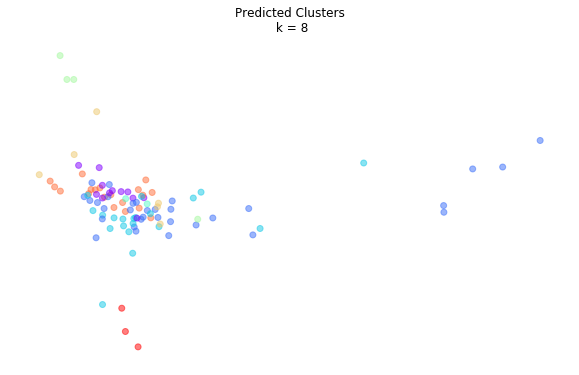

In [70]:
# Plot the data with predicted clusters
plot_colors8 = list(plt.cm.rainbow(np.linspace(0, 1, 8)))
plot_colors_p8 = [plot_colors8[l] for l in plotKM8.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors_p8, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 8')
plt.show()

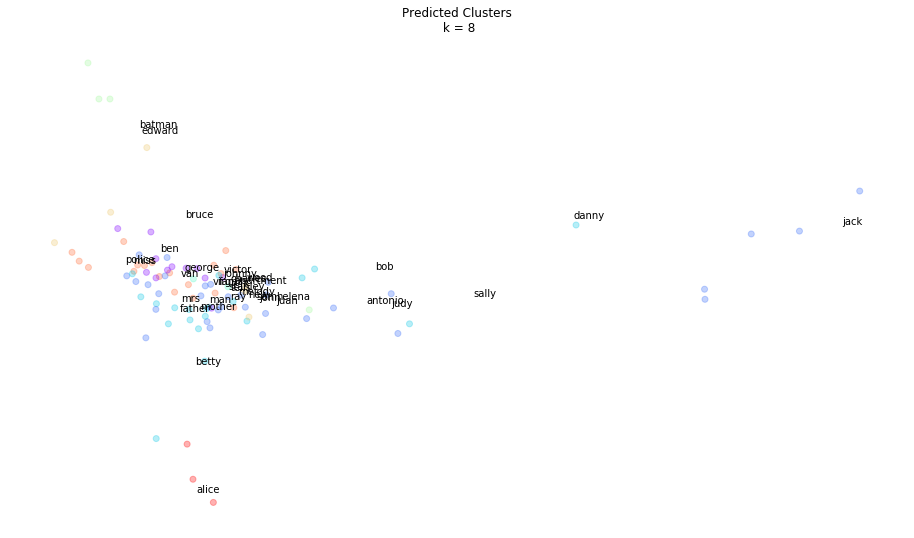

In [71]:
# Do a biplot and map our feature vectors with predicted clusters
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(plot_reduced_data[:, 0], plot_reduced_data[:, 1], color = plot_colors_p8, alpha = 0.3, label = plot_colors_p8)
for i, word in enumerate(plot_words):
    ax.annotate(word, (plot_x[i], plot_y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 8')
plt.show()

The flat clustering method performs best with cluster number 8 on my corpora while the plot summaries in my corpora are from four different directors, which means that the flat clustering method does not cluster my corpora by director correctly. By comparing the plot of the data with predicted labels and the true labels, we can observe that most documents are centralized but there are several films by different directors disperse in different directions. This might explain why the flat clustering method is not able to cluster the documents by directors, which is because most stories or settings of the films by the four directors are similar, and all four directors have also directed quite different films from their ordinary films. Another reason that may account for the underperformance of the flat clustering method is the limited number of documents in this corpora. By examining the cluster contents, we can see that names show up a lot, thus, we can also remove all the character names and actor names to improve the performance of clusterings.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [72]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 100 texts.

In [73]:
linkage_matrix = scipy.cluster.hierarchy.ward(newsgroupsCoocMat[:100, :100].toarray())
linkage_matrix[:10]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[  3.        ,  26.        ,   0.        ,   2.        ],
       [ 52.        , 100.        ,   0.        ,   3.        ],
       [ 68.        , 101.        ,   0.        ,   4.        ],
       [ 75.        , 102.        ,   0.        ,   5.        ],
       [ 76.        , 103.        ,   0.        ,   6.        ],
       [ 82.        , 104.        ,   0.        ,   7.        ],
       [ 99.        , 105.        ,   0.        ,   8.        ],
       [ 71.        ,  97.        ,   0.28035552,   2.        ],
       [ 22.        ,  55.        ,   0.28134893,   2.        ],
       [ 21.        , 107.        ,   0.31355623,   3.        ]])

Now we can visualize the tree

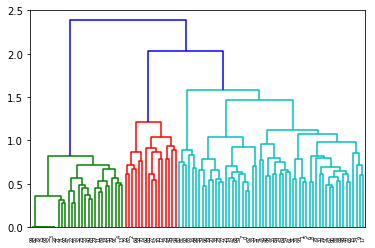

In [74]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

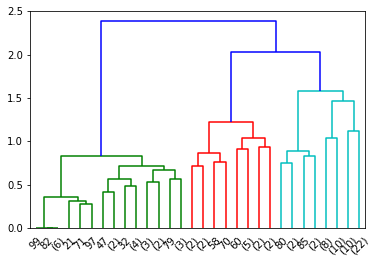

In [75]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level')

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters

In [76]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 2, 1, 2, 1, 4, 4, 3, 4, 1, 4, 4, 1,
       1, 2, 4, 4, 1, 2, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 2,
       4, 4, 4, 1, 4, 2, 1, 4, 1, 1, 4, 1, 4, 2, 2, 4, 2, 4, 4, 1, 2, 4,
       4, 4, 1, 4, 2, 1, 2, 1, 4, 1, 1, 4, 4, 1, 3, 3, 1, 2, 4, 3, 4, 2,
       4, 1, 4, 1, 3, 4, 2, 4, 4, 1, 3, 1], dtype=int32)

This gives us an array giving each element of `linkage_matrix`'s cluster. The leader function below is actually quite misleading. In this case, the ids it returns are actually not document ids but non-singleton clusters. You can ignore this cell.

In [77]:
clusterLeaders = scipy.cluster.hierarchy.leaders(linkage_matrix, hierarchicalClusters)
clusterLeaders

(array([183, 195, 194, 178], dtype=int32), array([3, 4, 2, 1], dtype=int32))

# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [78]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

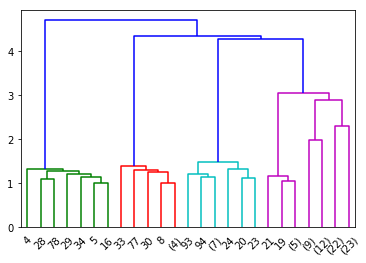

In [79]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Sometimes, it's not very interesting :-).

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? 

In [80]:
# Create a word occurrence matrix 
# measuring how similar the documents are to each other based on their number of shared words
plotCoocMat = plotTFVects * plotTFVects.T
plotCoocMat.setdiag(0)

In [81]:
# Compute a tree of nested clusters
plot_linkage_matrix = scipy.cluster.hierarchy.ward(plotCoocMat.toarray())
plot_linkage_matrix[:10]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 53.        ,  84.        ,   0.15758806,   2.        ],
       [ 65.        ,  98.        ,   0.19297524,   3.        ],
       [ 40.        ,  99.        ,   0.22542363,   4.        ],
       [ 94.        , 100.        ,   0.23561698,   5.        ],
       [ 24.        , 101.        ,   0.24187876,   6.        ],
       [ 21.        ,  90.        ,   0.26783527,   2.        ],
       [ 39.        ,  76.        ,   0.27007356,   2.        ],
       [ 27.        ,  87.        ,   0.27234924,   2.        ],
       [ 34.        ,  96.        ,   0.27372243,   2.        ],
       [ 33.        ,  71.        ,   0.27499796,   2.        ]])

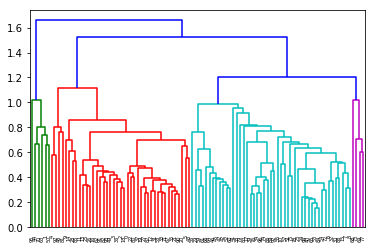

In [82]:
# Visualize the tree
ax = scipy.cluster.hierarchy.dendrogram(plot_linkage_matrix)

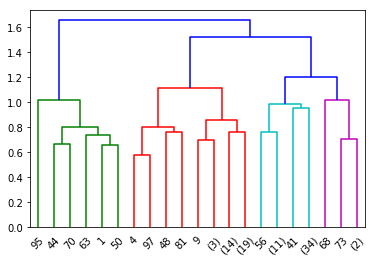

In [83]:
# Cut the tree after a number of branchings
ax = scipy.cluster.hierarchy.dendrogram(plot_linkage_matrix, p=4, truncate_mode='level')

In [84]:
# Another approach involves cutting the tree into n branches
plot_hierarchicalClusters = scipy.cluster.hierarchy.fcluster(plot_linkage_matrix, 4, 'maxclust')
plot_hierarchicalClusters

array([2, 1, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2,
       1, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 3, 3,
       3, 2, 4, 4, 1, 2, 3, 4, 3, 3, 3, 4, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2,
       3, 3, 2, 2, 3, 2, 3, 1, 3, 2], dtype=int32)

In [85]:
# Evaluate the clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(plot['director'], plot_hierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(plot['director'], plot_hierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(plot['director'], plot_hierarchicalClusters)))

Homogeneity: 0.121
Completeness: 0.155
V-measure: 0.136


In [86]:
# Look at the cluster contents in terms of documents
plot['wald_pred'] = plot_hierarchicalClusters
plot

,director,plot,KM_preds,wald_pred
0,Alfred Hitchcock,"A young blonde woman, her golden hair illumina...",1,2
1,Alfred Hitchcock,A previously undefeated fairground boxer named...,1,1
2,Alfred Hitchcock,At an expensive English boarding school for bo...,2,2
3,Alfred Hitchcock,"In 1926, Larita Filton (Isabel Jeans) testifie...",1,2
4,Alfred Hitchcock,The Heiress Betty (Betty Balfour) draws the ir...,2,2
5,Alfred Hitchcock,"Barry Fitzgerald, who played Captain Jack Boyl...",0,2
6,Alfred Hitchcock,"In 1930, Diana Baring (Norah Baring), a young ...",6,3
7,Alfred Hitchcock,The plot concerns a feud between two affluent ...,6,3
8,Alfred Hitchcock,"A couple, Fred (Henry Kendall) and Emily Hill ...",2,3
9,Alfred Hitchcock,Detective Barton is searching for a necklace s...,5,2


In [87]:
print('Alfred Hitchcock:')
print(plot[plot['director'] == 'Alfred Hitchcock'].wald_pred.value_counts(), '\n')
print('Woody Allen:')
print(plot[plot['director'] == 'Woody Allen'].wald_pred.value_counts(), '\n')
print('Tim Burton:')
print(plot[plot['director'] == 'Tim Burton'].wald_pred.value_counts(), '\n')
print('Stanley Kubrick:')
print(plot[plot['director'] == 'Stanley Kubrick'].wald_pred.value_counts())

Alfred Hitchcock:
2    25
3    12
1     1
Name: wald_pred, dtype: int64 

Woody Allen:
3    21
2     5
1     3
Name: wald_pred, dtype: int64 

Tim Burton:
3    8
2    6
4    4
1    1
Name: wald_pred, dtype: int64 

Stanley Kubrick:
3    6
2    5
1    1
Name: wald_pred, dtype: int64


By observing the structure and color of the tree, we can see that by Wald's Method, the corpora is naturally clustered into four classes, which is the same number as the number of directors in this corpora. Moreover, the accuracy of the four hierarchical clusters is similar to the eight flat clusters by K Means, which indicates the great performance of hierarchical clustering. After closer analyzing the cluters, I found that most of Woody Allen's films are catrgorized into one cluster, about two thirds of Alfred Hitchcock's films are catrgorized into another cluster, and most of the four directors' films are all categorized into these two clusters. Around one third of Tim Burton's films are categorized into another class. This finding agrees with the results of flat clustering above, that most films from four directors are similar and all four directors have a small proportion of quite different productions. Some other information we can get from the hierarchical clustering is that most of Woody Allen's films are similar, Tim Burton and Stanley Kubrick are the most different ones among the four directors. This agrees with our understanding of the four directors as Tim Burton and Stanley Kubrick are known for their diverse styles and Woody Allen has a somehow consistent romantic style. 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpus` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [100]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens,reduced_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli...","[contact, wagon, brent, carney, intern, depart..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,...","[follow, patriot, extra, concern, patriot, coo..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c...","[follow, bird, flu, yesterday, respond, outbre..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer...","[endless, danger, skyrocket, gas, price, seaso..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ...","[follow, pension, sad, holiday, season, gift, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,...","[patrick, richard, durbin, follow, attorney, a..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,...","[veteran, stand, brave, greatest, ideal, thous..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,...","[hear, commit, track, understand, english, com..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,...","[follow, cia, leak, ordeal, term, govern, clea..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,...","[direct, corp, assist, gateway, water, instruc..."


In [101]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [102]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [103]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [104]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [105]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [106]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(1, 0.9689527)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [107]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [108]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(1, 0.9568645)]",0.000000,0.956864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(5, 0.992256)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.992256,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(3, 0.9970438)]",0.000000,0.000000,0.000000,0.997044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(0, 0.51063895), (2, 0.33401394), (4, 0.05718...",0.510639,0.000000,0.334014,0.000000,0.057183,0.065807,0.000000,0.000000,0.030874,0.000000
401,08Feb2005Kennedy0.txt,"[(3, 0.9869543)]",0.000000,0.000000,0.000000,0.986954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(0, 0.22572133), (1, 0.719667)]",0.225721,0.719667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(0, 0.5194936), (6, 0.44415128)]",0.519494,0.000000,0.000000,0.000000,0.000000,0.000000,0.444151,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(9, 0.99600446)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996004
801,15Dec2005Kennedy5.txt,"[(1, 0.028278848), (2, 0.43557638), (6, 0.4004...",0.000000,0.028279,0.435576,0.000000,0.000000,0.000000,0.400441,0.015841,0.118618,0.000000
901,16May2007Kennedy5.txt,"[(6, 0.72877514), (9, 0.23285757)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728775,0.000000,0.000000,0.232858


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [109]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.968952,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
1,0.000000,0.956864,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.914677,0.07754,0.0,0.0,0.000000,0.0
3,0.175327,0.000000,0.000000,0.765584,0.052549,0.00000,0.0,0.0,0.000000,0.0
4,0.000000,0.554504,0.000000,0.000000,0.426344,0.00000,0.0,0.0,0.016697,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.986302,0.0
6,0.000000,0.000000,0.178495,0.000000,0.805069,0.00000,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.962175,0.00000,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.000000,0.320118,0.666704,0.00000,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.000000,0.966080,0.00000,0.0,0.0,0.000000,0.0


First we can visualize as a stacked bar chart:

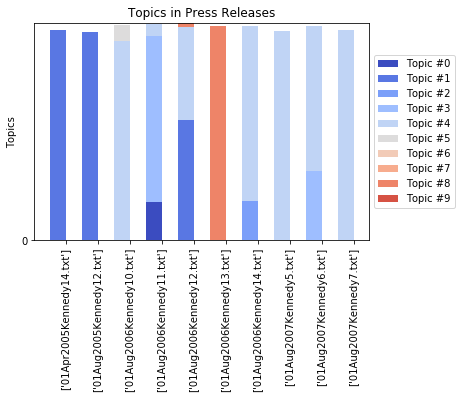

In [110]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

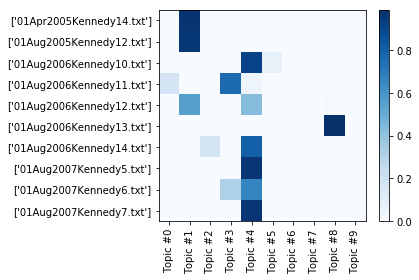

In [111]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [112]:
senlda.show_topic(1)

[('fund', 0.021571185),
 ('worker', 0.017805528),
 ('trust', 0.008991669),
 ('victim', 0.00868565),
 ('wage', 0.006695598),
 ('depart', 0.0063481233),
 ('wagon', 0.0060842587),
 ('unit', 0.005628031),
 ('import', 0.0054492005),
 ('document', 0.0053375415)]

And if we want to make a dataFrame:

In [113]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,fund,fund,worker,loan,fund,worker,head,minimum,head
1,wagon,worker,worker,fund,worker,unit,fund,depart,worker,wage
2,troop,trust,wagon,cell,wage,wagon,loan,fund,wage,fund
3,author,victim,import,stem,lender,troop,wagon,import,fund,worker
4,commit,wage,train,pension,mental,iraqi,import,worker,loan,minimum
5,import,depart,respond,depart,rate,fail,lender,base,head,depart
6,worker,wagon,pell,teacher,employ,govern,employ,wagon,govern,commit
7,govern,unit,author,govern,govern,import,teacher,govern,import,wagon
8,amend,import,depart,import,minimum,depart,unit,author,pension,govern
9,wage,document,follow,wagon,inform,author,commit,attorney,amend,test


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

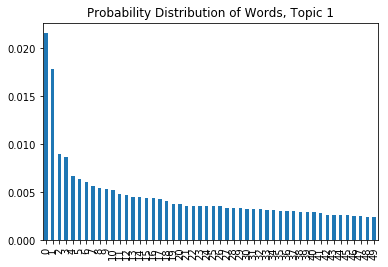

In [114]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [115]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

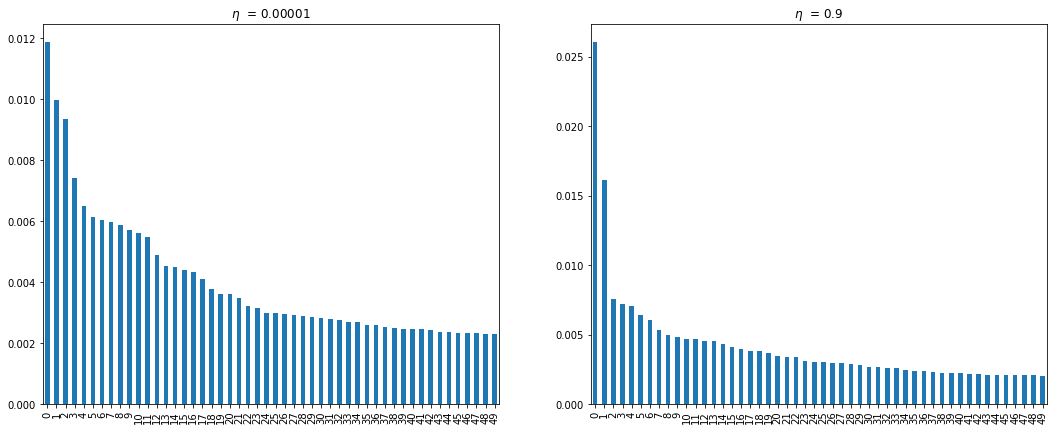

In [116]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [117]:
# Aggregate the plot summaries of each director together
plot_aggr = plot.groupby('director').apply(lambda x: x.sum()).drop(columns = ['director', 'KM_preds', 'wald_pred'])

In [118]:
plot_aggr

,plot
director,
Alfred Hitchcock,"A young blonde woman, her golden hair illumina..."
Stanley Kubrick,The story is set during a war between two unid...
Tim Burton,Pee-wee Herman has a heavily accessorized bicy...
Woody Allen,Virgil Starkwell's (Woody Allen) story is told...


In [119]:
# Create a Dictionary that maps tokens to ids
plot_aggr['tokenized_plot'] = plot_aggr['plot'].apply(lambda x: nltk.word_tokenize(x))
plot_aggr['normalized_tokens'] = plot_aggr['tokenized_plot'].apply(lambda x: lucem_illud.normalizeTokens(x,
                                 stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))
plot_aggr['reduced_tokens'] = plot_aggr['normalized_tokens'].apply(lambda x: dropMissing(x, plotTFVectorizer.vocabulary_.keys()))
plot_dictionary = gensim.corpora.Dictionary(plot_aggr['reduced_tokens'])

In [120]:
# For each of the texts create a list of tuples containing each token and its count
plot_corpus = [plot_dictionary.doc2bow(text) for text in plot_aggr['reduced_tokens']]

In [121]:
# Serialize the corpus as a file and load it
gensim.corpora.MmCorpus.serialize('plot.mm', plot_corpus)
plotmm = gensim.corpora.MmCorpus('plot.mm')

In [122]:
# Now we have a correctly formatted corpus that we can use for topic modeling and induction
plotlda = gensim.models.ldamodel.LdaModel(corpus=plotmm, id2word=plot_dictionary, num_topics=10, alpha='auto', eta='auto')

In [123]:
# Inspect the degree to which distinct texts load on different topics
plot1Bow = plot_dictionary.doc2bow(plot_aggr['reduced_tokens'][0])
plot1lda = plotlda[plot1Bow]
print("The topics of the plot summaries from {}".format(plot_aggr.index[0]), "are: {}".format(plot1lda))

The topics of the plot summaries from Alfred Hitchcock are: [(1, 0.041210994), (4, 0.020199139), (5, 0.61851317), (6, 0.21490604), (7, 0.07570475), (9, 0.027314203)]


In [124]:
# Construct a pandas dataframe to see which topics our model predicts the plot summary load on
plot_ldaDF = pandas.DataFrame({
        'director' : plot_aggr.index,
        'topics' : [plotlda[plot_dictionary.doc2bow(l)] for l in plot_aggr['reduced_tokens']]
    })

# Make each topic its own column
## Dict to temporally hold the probabilities
plot_topicsProbDict = {i : [0] * len(plot_ldaDF) for i in range(plotlda.num_topics)}

## Load them into the dict
for index, topicTuples in enumerate(plot_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        plot_topicsProbDict[topicNum][index] = prob

## Update the DataFrame
for topicNum in range(plotlda.num_topics):
    plot_ldaDF['topic_{}'.format(topicNum)] = plot_topicsProbDict[topicNum]

In [125]:
plot_ldaDF

,director,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Alfred Hitchcock,"[(1, 0.04320307), (4, 0.02872054), (5, 0.62437...",0,0.043203,0,0.000000,0.028721,0.624375,0.198507,0.074012,0,0.029034
1,Stanley Kubrick,"[(4, 0.015068045), (6, 0.017673166), (7, 0.955...",0,0.000000,0,0.000000,0.015068,0.000000,0.017673,0.955803,0,0.000000
2,Tim Burton,"[(4, 0.93421537), (7, 0.06443202)]",0,0.000000,0,0.000000,0.934215,0.000000,0.000000,0.064432,0,0.000000
3,Woody Allen,"[(1, 0.04676491), (3, 0.049302537), (4, 0.2570...",0,0.046765,0,0.049303,0.257087,0.646544,0.000000,0.000000,0,0.000000


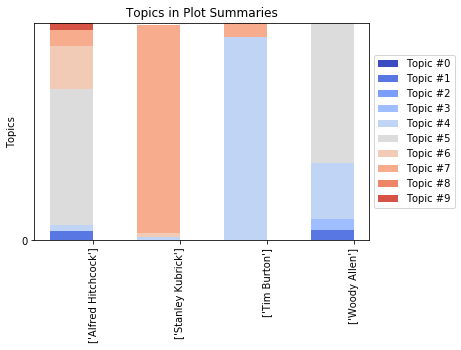

In [126]:
# Visualize as a stacked bar chart
N = 4
K = plotlda.num_topics  # N documents, K topics
plot_ldaDFVis = plot_ldaDF[['topic_%d' %x for x in range(K)]].as_matrix(columns=None)
plot_ldaDFVisNames = plot_ldaDF[['director']].as_matrix(columns=None)

ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, plot_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, plot_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += plot_ldaDFVis[:, k]
    plots.append(p)
    
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Plot Summaries')
plt.xticks(ind+width/2, plot_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

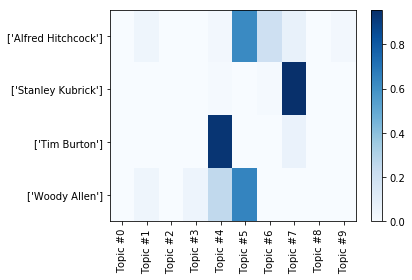

In [127]:
# Visualize as a heat map
plt.pcolor(plot_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(plot_ldaDFVis.shape[0])+0.5, plot_ldaDFVisNames);
plt.xticks(np.arange(plot_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [128]:
# look at the top words from each topic
plotlda.show_topic(0)

[('tell', 0.011366297),
 ('kill', 0.010088869),
 ('return', 0.009090408),
 ('jack', 0.009087593),
 ('man', 0.006094615),
 ('say', 0.005903715),
 ('meet', 0.0058282805),
 ('murder', 0.0056613307),
 ('new', 0.0055010743),
 ('reveal', 0.0053378884)]

In [129]:
# Make a pandas dataframe to look at the top words from each topic
plot_topicsDict = {}
for topicNum in range(plotlda.num_topics):
    topicWords = [w for w, p in plotlda.show_topic(topicNum)]
    plot_topicsDict['Topic_{}'.format(topicNum)] = topicWords

plot_wordRanksDF = pandas.DataFrame(plot_topicsDict)
plot_wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,tell,jack,tell,tell,return,tell,jack,kill,jack,tell
1,kill,tell,meet,jack,tell,jack,tell,jack,tell,jack
2,return,love,kill,kill,kill,reveal,kill,tell,return,return
3,jack,kill,edward,ask,jack,kill,murder,return,love,kill
4,man,wife,jack,return,father,new,return,wife,kill,father
5,say,new,return,new,love,murder,meet,edward,home,meet
6,meet,make,new,wife,edward,meet,father,meet,new,ask
7,murder,later,father,man,wife,home,say,home,edward,bob
8,new,return,man,time,new,film,wife,attempt,meet,reveal
9,reveal,man,home,begin,live,use,later,later,wife,say


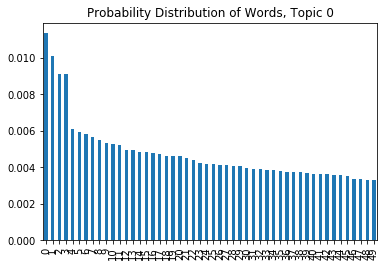

In [130]:
# Visualization of the distribution of words over any single topic
plot_topic0_df = pandas.DataFrame(plotlda.show_topic(0, topn=50))
plt.figure()
plot_topic0_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 0')
plt.show()

As illsutrated before, the documents are quite aggregated on topics which means that the films of each director are mostly similar on topic. However, apparently, the top words in the ten topics overlap a lot and the four documents only load on seven topics. To observe more distinctive outcomes, we need to decrease the number of topics and adjust the parameters of the model $\alpha$ and $\eta$.

I first construct several functions to make it easier to repeat the above steps.

In [131]:
# Topic modeling
def topic_modeling(plot_num_topics, plot_alpha, plot_eta, plot_corpus=plotmm, plot_id2word=plot_dictionary):
    plotlda = gensim.models.ldamodel.LdaModel(corpus=plot_corpus, id2word=plot_id2word, num_topics=plot_num_topics, alpha=plot_alpha, eta=plot_eta)
    return plotlda

In [132]:
# Construct a pandas dataframe to see which topics our model predicts the plot summary load on
def plot_topic_DF(plotlda, dictionary=plot_dictionary, plotDF=plot_aggr):
    
    plot_ldaDF = pandas.DataFrame({
                    'director' : plotDF.index,
                    'topics' : [plotlda[dictionary.doc2bow(l)] for l in plotDF['reduced_tokens']]
                 })

    # Make each topic its own column
    ## Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(plot_ldaDF) for i in range(plotlda.num_topics)}

    ## Load them into the dict
    for index, topicTuples in enumerate(plot_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    ## Update the DataFrame
    for topicNum in range(plotlda.num_topics):
        plot_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
        
    return plot_ldaDF

In [133]:
def prepare_plot(plotlda, plot_ldaDF):
    K = plotlda.num_topics  # K topics
    plot_ldaDFVis = plot_ldaDF[['topic_%d' %x for x in range(K)]].as_matrix(columns=None)
    plot_ldaDFVisNames = plot_ldaDF[['director']].as_matrix(columns=None)
    return K, plot_ldaDFVis, plot_ldaDFVisNames

In [134]:
# Visualize as a stacked bar chart
def bar_chart(K, plot_ldaDFVis, plot_ldaDFVisNames):
    N = 4 # N documents
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, plot_ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, plot_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += plot_ldaDFVis[:, k]
        plots.append(p)

    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title('Topics in Plot Summaries')
    plt.xticks(ind+width/2, plot_ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [135]:
# Visualize as a heat map
def heat_map(K, plot_ldaDFVis, plot_ldaDFVisNames):
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.pcolor(plot_ldaDFVis, norm=None, cmap='Blues')
    plt.yticks(np.arange(plot_ldaDFVis.shape[0])+0.5, plot_ldaDFVisNames);
    plt.xticks(np.arange(plot_ldaDFVis.shape[1])+0.5, topic_labels);

    # flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
    plt.gca().invert_yaxis()

    # rotate the ticks on the x-axis
    plt.xticks(rotation=90)

    # add a legend
    plt.colorbar(cmap='Blues')
    plt.tight_layout()  # fixes margins
    plt.show()

In [136]:
# Make a pandas dataframe to look at the top words from each topic
def topic_top_words(plotlda):
    plot_topicsDict = {}
    for topicNum in range(plotlda.num_topics):
        topicWords = [w for w, p in plotlda.show_topic(topicNum)]
        plot_topicsDict['Topic_{}'.format(topicNum)] = topicWords

    plot_wordRanksDF = pandas.DataFrame(plot_topicsDict)
    return plot_wordRanksDF

In [137]:
# Visualization of the distribution of words over any single topic
def topic_words_dist(plotlda, topic_number):
    plot_topic_df = pandas.DataFrame(plotlda.show_topic(topic_number, topn=50))
    plt.figure()
    plot_topic_df.plot.bar(legend = False)
    plt.title('Probability Distribution of Words, Topic {}'.format(topic_number))
    plt.show()

Then we can change the number of topics, $\alpha$, and $\eta$ to see the difference.

           director                                             topics  \
0  Alfred Hitchcock  [(0, 0.03318647), (3, 0.25605783), (5, 0.70711...   
1   Stanley Kubrick  [(0, 0.02319025), (3, 0.030400623), (5, 0.9462...   
2        Tim Burton  [(2, 0.045696057), (3, 0.18497422), (5, 0.7585...   
3       Woody Allen  [(0, 0.039847482), (1, 0.57053345), (2, 0.3521...   

    topic_0   topic_1   topic_2   topic_3  topic_4   topic_5  
0  0.033186  0.000000  0.000000  0.256058        0  0.707117  
1  0.023190  0.000000  0.000000  0.030401        0  0.946258  
2  0.000000  0.000000  0.045696  0.184974        0  0.758593  
3  0.039847  0.570533  0.352181  0.000000        0  0.031940  


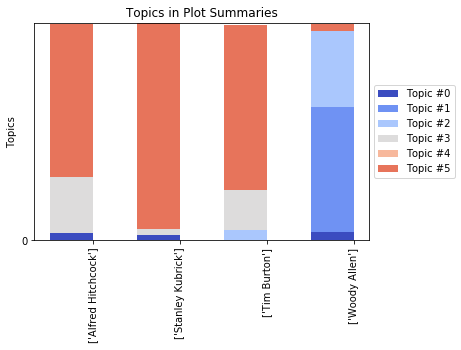

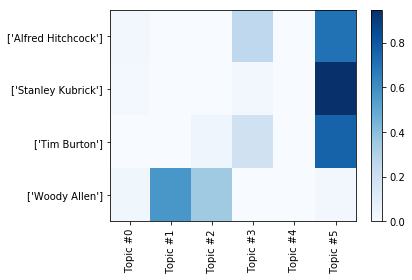

  Topic_0 Topic_1 Topic_2 Topic_3  Topic_4 Topic_5
0    jack    tell    jack    kill     tell    tell
1    tell    kill    tell    jack     kill    jack
2    kill  return    love    tell     jack  return
3  return     new    kill  return     wife    kill
4     man    meet    meet  father      say    meet
5    love    jack  edward    wife  attempt  reveal
6    home    love  return   later   father     new
7    wife    make    film     ask     meet  edward
8     new  reveal   later     new   edward  murder
9     say     ask     new    home   return     ask


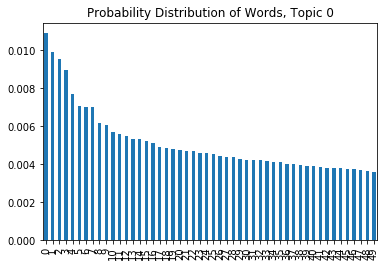

In [180]:
# plot_num_topics=6, plot_alpha=0.1, plot_eta=0.1
plotlda1 = topic_modeling(plot_num_topics=6, plot_alpha=0.1, plot_eta=0.1)
plot_ldaDF1 = plot_topic_DF(plotlda1)
print(plot_ldaDF1)
K1, plot_ldaDFVis1, plot_ldaDFVisNames1 = prepare_plot(plotlda1, plot_ldaDF1)
bar_chart(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
heat_map(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
print(topic_top_words(plotlda1))
topic_words_dist(plotlda1, 0)

When limit the number of topics to six, we can observe that there are no topics without any loadings, which indicates that the choice of six topics is more reasonable than ten. With $\alpha$ and $\eta$ both equal to 0.1, the topic modeling result imply that all the four directors have predominantly personal film styles in regards to topics. Among the four directors, Stanley Kubrick has the most consistent topic style, Tim Burton and Alfred Hitchcock respectively have two primary topic styles and has very few films in some other topic styles, and Woody Allen has the most diverse topic styles. This result does not agree with the common understanding of these four directors. As we usually think that Stanley Kubrick has the most diverse cinematic styles and Alfred Hitchcock and Woody Allen has somehow more consistent cinematic styles. After analyzing the top words in each topic, we can see that though with slight difference, there are way too much overlap. Therefore, to oberseve more reasonable results, some adjustment on $\alpha$ and $\eta$ is necessary. Since $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings, decreasing $\alpha$ would make each document being composed of fewer dominant topics, and decreasing $\eta$ would make each topic being composed of fewer dominant words. Thus, I first increase the value of $\eta$ to make each topic being composed of more words so as to be more distinct.

           director                                             topics  \
0  Alfred Hitchcock  [(1, 0.62737566), (2, 0.012700282), (3, 0.2860...   
1   Stanley Kubrick  [(0, 0.0494723), (1, 0.18341927), (2, 0.140980...   
2        Tim Burton                                   [(2, 0.9998539)]   
3       Woody Allen  [(1, 0.24503586), (3, 0.1805641), (4, 0.088676...   

    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  
0  0.000000  0.627376  0.012700  0.286024  0.044186  0.020821  
1  0.049472  0.183419  0.140980  0.023638  0.378298  0.224191  
2  0.000000  0.000000  0.999854  0.000000  0.000000  0.000000  
3  0.000000  0.245036  0.000000  0.180564  0.088676  0.484041  


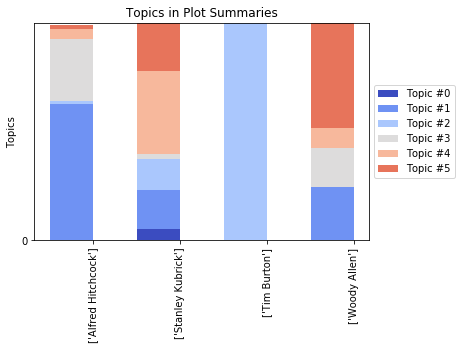

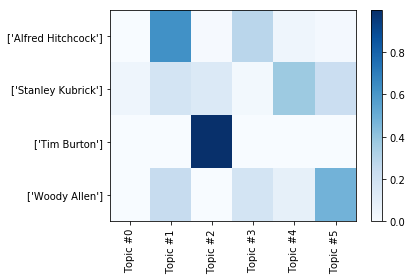

  Topic_0 Topic_1 Topic_2 Topic_3 Topic_4 Topic_5
0    kill    tell    kill    jack    tell    tell
1  return    jack    tell    tell    jack    meet
2    tell  return  edward    kill  return    jack
3    jack    kill    jack     new     man  return
4     new    meet  batman    love    kill    kill
5    love     ask  victor    wife    love     say
6  father  reveal  reveal  return  reveal   later
7   later     bob  return    meet    home     ask
8     ask    make    home     say    wife     new
9     say  father    meet     ask     new    wife


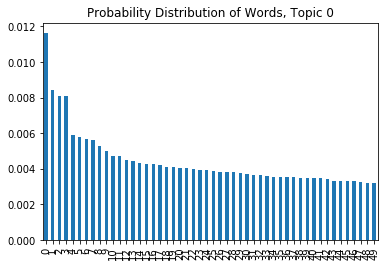

In [164]:
# plot_num_topics=6, plot_alpha=0.1, plot_eta=0.5
plotlda1 = topic_modeling(plot_num_topics=6, plot_alpha=0.1, plot_eta=0.5)
plot_ldaDF1 = plot_topic_DF(plotlda1)
print(plot_ldaDF1)
K1, plot_ldaDFVis1, plot_ldaDFVisNames1 = prepare_plot(plotlda1, plot_ldaDF1)
bar_chart(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
heat_map(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
print(topic_top_words(plotlda1))
topic_words_dist(plotlda1, 0)

           director                                             topics  \
0  Alfred Hitchcock  [(0, 0.012391001), (2, 0.2734241), (3, 0.70970...   
1   Stanley Kubrick                                   [(2, 0.9885867)]   
2        Tim Burton  [(0, 0.03970452), (1, 0.53291124), (3, 0.40874...   
3       Woody Allen  [(2, 0.90630054), (3, 0.016811823), (5, 0.0727...   

    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  
0  0.012391  0.000000  0.273424  0.709701  0.000000  0.000000  
1  0.000000  0.000000  0.988587  0.000000  0.000000  0.000000  
2  0.039705  0.532911  0.000000  0.408741  0.010895  0.000000  
3  0.000000  0.000000  0.906301  0.016812  0.000000  0.072746  


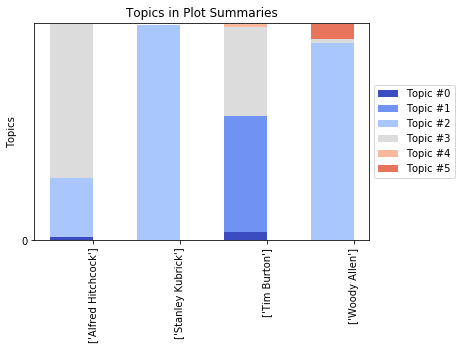

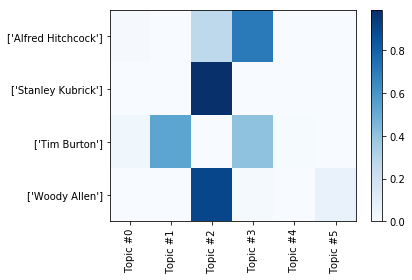

  Topic_0 Topic_1 Topic_2 Topic_3 Topic_4  Topic_5
0    tell    tell    jack    jack    kill     kill
1    jack    kill    tell    tell    tell     tell
2    kill  return  return    kill    jack   return
3  return  edward    kill  return  return     love
4  father  reveal     say  edward  father      new
5     ask    jack     new  murder  edward     meet
6  edward    meet     man    meet  friend     wife
7  reveal  father    love     new    room     life
8    meet    time    meet  reveal    home  attempt
9    love     use    wife  father    wife     film


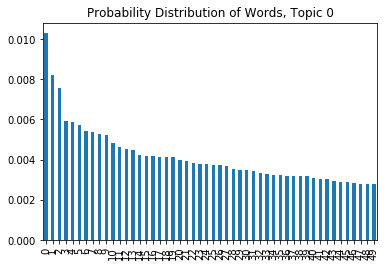

In [165]:
# plot_num_topics=6, plot_alpha=0.1, plot_eta=0.9
plotlda1 = topic_modeling(plot_num_topics=6, plot_alpha=0.1, plot_eta=0.9)
plot_ldaDF1 = plot_topic_DF(plotlda1)
print(plot_ldaDF1)
K1, plot_ldaDFVis1, plot_ldaDFVisNames1 = prepare_plot(plotlda1, plot_ldaDF1)
bar_chart(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
heat_map(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
print(topic_top_words(plotlda1))
topic_words_dist(plotlda1, 0)

As I have expected, increasing the value of $\eta$ does make the top words of each topic more distinct. Now we have "kill" and "father" in Topic 0, "meet" and "ask" in Topic 1, "edward" and "batman" in Topic 2, "love" and "wife" in Topic 3, "man" and "home" in Topic 4, "meet" and "later" in Topic 5. At the same time, the topic component of each document changes as well. It seems that when $\eta$ equals 0.5, the topics included in each director's films are very diverse, and when $\eta$ equals 0.9, all directors are mostly creating films of the same topic. It seems that it is more informative when $\eta$ equals 0.5. In this case, Alfred Hitchcock is composed mainly of Topic 1 and 3, about "kill", "reveal", "love", "wife"; this makes sense as these seems like topics about horror stories. Stanley Kubric is composed of most topics, which makes snese as we know that Stanley Kubric is known as his diverse cinematic styles. Tim Burton has only one topic, Topic 2, about "kill", "edward", "batman"; this makes sense as "edward" and "batman" are characters in Tim Burton's films. Woody Allen is mainly composed of Topic 5, 1, and 3, which are about "tell", "meet", "love", "wife", which also makes sense as they look like the key words that usually appear in romatic stories. It is also interesting to observe that "jack" appears in all topics, which makes it the most popular name across films. I guess a comparison between names used in different films and real census data of name usage might be fun. Next, I would increase the value $\alpha$ to see if it would allow the films of each director to be composed of more topics.

           director                                             topics  \
0  Alfred Hitchcock  [(0, 0.017786222), (1, 0.2378139), (2, 0.65311...   
1   Stanley Kubrick  [(0, 0.20492135), (2, 0.03699395), (4, 0.75065...   
2        Tim Burton  [(2, 0.2612866), (3, 0.117110886), (4, 0.60850...   
3       Woody Allen  [(1, 0.095101796), (2, 0.7135967), (4, 0.18721...   

    topic_0   topic_1   topic_2   topic_3   topic_4  topic_5  
0  0.017786  0.237814  0.653120  0.000000  0.090856        0  
1  0.204921  0.000000  0.036994  0.000000  0.750658        0  
2  0.000000  0.000000  0.261287  0.117111  0.608500        0  
3  0.000000  0.095102  0.713597  0.000000  0.187214        0  


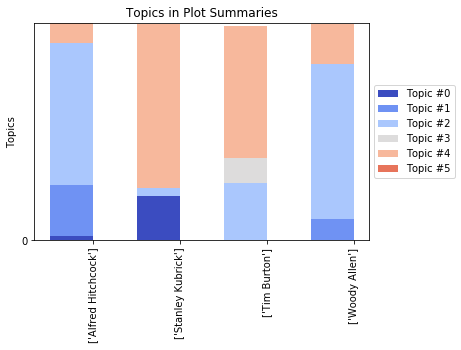

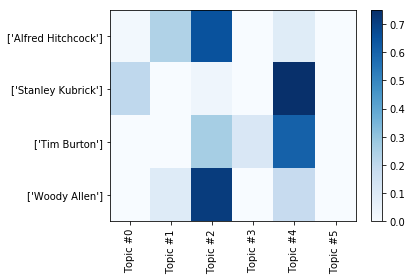

  Topic_0 Topic_1 Topic_2  Topic_3 Topic_4 Topic_5
0    tell    tell    jack     tell    tell    tell
1    jack    kill    tell   edward    jack    kill
2    kill    jack    kill     kill  return  return
3  return  return  father     jack    kill    meet
4    meet  reveal     new   return    home    jack
5  reveal    love  return   father     ask     ask
6   later    meet  edward     meet     new     use
7     new     ask    wife  attempt    love     man
8     say    wife     say     wife     man    year
9  murder  father    meet   reveal   later  reveal


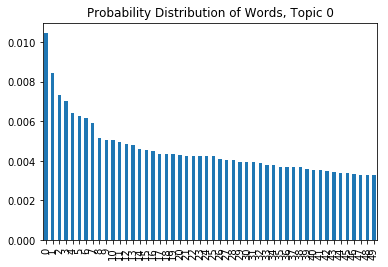

In [168]:
# plot_num_topics=6, plot_alpha=0.5, plot_eta=0.5
plotlda1 = topic_modeling(plot_num_topics=6, plot_alpha=0.5, plot_eta=0.5)
plot_ldaDF1 = plot_topic_DF(plotlda1)
print(plot_ldaDF1)
K1, plot_ldaDFVis1, plot_ldaDFVisNames1 = prepare_plot(plotlda1, plot_ldaDF1)
bar_chart(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
heat_map(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
print(topic_top_words(plotlda1))
topic_words_dist(plotlda1, 0)

           director                                             topics  \
0  Alfred Hitchcock  [(0, 0.45040748), (1, 0.069065005), (2, 0.4040...   
1   Stanley Kubrick  [(0, 0.4433849), (1, 0.19681944), (2, 0.238491...   
2        Tim Burton  [(0, 0.013776369), (3, 0.4457193), (4, 0.53473...   
3       Woody Allen  [(1, 0.018522173), (2, 0.101553716), (3, 0.026...   

    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  
0  0.450407  0.069065  0.404083  0.020532  0.054399  0.000000  
1  0.443385  0.196819  0.238491  0.098289  0.018356  0.000000  
2  0.013776  0.000000  0.000000  0.445719  0.534737  0.000000  
3  0.000000  0.018522  0.101554  0.026989  0.016451  0.829661  


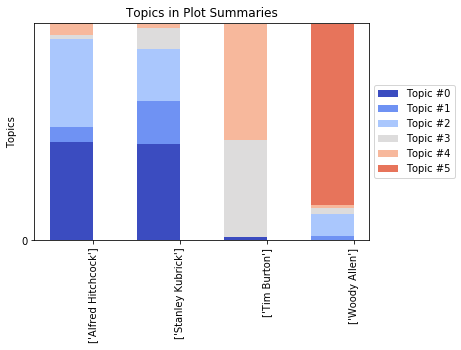

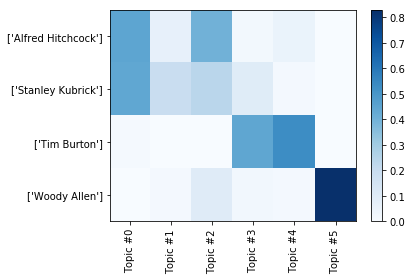

  Topic_0 Topic_1 Topic_2 Topic_3 Topic_4 Topic_5
0    tell    kill    tell    tell    kill    tell
1    kill    tell    jack    jack    jack    jack
2    jack  return    kill  return     new    meet
3  return    jack  return    kill    tell    love
4  father    wife    wife    home  edward     ask
5    home    meet    meet  edward    love     new
6     ask     ask  friend   later  reveal  return
7    meet  murder     man     say  return    wife
8  edward     man   later  reveal  murder    life
9     man  father     new    love    meet    kill


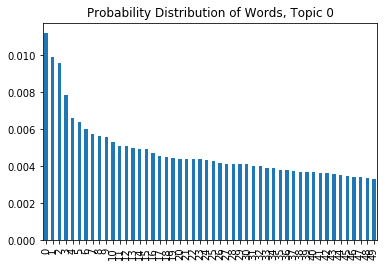

In [170]:
# plot_num_topics=6, plot_alpha=0.9, plot_eta=0.5
plotlda1 = topic_modeling(plot_num_topics=6, plot_alpha=0.9, plot_eta=0.5)
plot_ldaDF1 = plot_topic_DF(plotlda1)
print(plot_ldaDF1)
K1, plot_ldaDFVis1, plot_ldaDFVisNames1 = prepare_plot(plotlda1, plot_ldaDF1)
bar_chart(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
heat_map(K1, plot_ldaDFVis1, plot_ldaDFVisNames1)
print(topic_top_words(plotlda1))
topic_words_dist(plotlda1, 0)

As we can observe, when I increase the value of $\alpha$, the films of each directors are composed of more topics or are more distributed among different topics. However, if we want to be more sure about our findings, we might need to set random seed, increase the number of iterations, and try more combination of the value of $\alpha$, $\eta$, and number of topics, to get more consistent results that is more interesting to be interpreted.